<a href="https://colab.research.google.com/github/andrew-veriga/MathForML/blob/master/ConvolutionalCoffieCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [2]:
import tensorflow as tf
import numpy as np

### Load picture

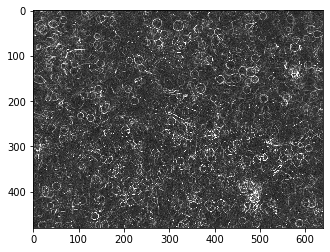

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path='https://github.com/andrew-veriga/MathForML/blob/master/CoffieCircles.png?raw=true'
#img_path='https://drive.google.com/file/d/1Nho1Ed_TnlSzTkJ0v0pc9dfvQH-HOws9/view?usp=sharing'
#img_path='https://www.dropbox.com/s/8naq7w6w2egpl6t/CoffieCircles.png?dl=0'
Image = mpimg.imread(img_path)
plt.imshow(Image)

In [4]:
print(Image.shape)

(480, 640, 4)


###Prepare picture
Convert Image to 2D

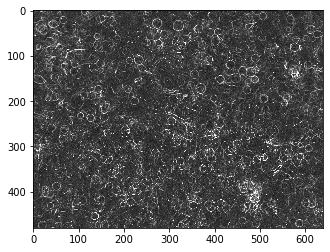

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Image = rgb2gray(Image)    
plt.imshow(Image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [6]:
print (Image.shape)

(480, 640)


###Init variables

`MaxSize` - max size of square region

`MinSize` - min size of square region

`Contrast` - scalar set contrast of recognizing ring 
`Thick` - thickness of ring
`FoundCircles` - numpy array of centers and radiuces (3,None)

In [0]:
firstX=1
firstY=1
ImageSize = (48,64) #Image.shape
MaxSize = 40 
MinSize = 10
Contrast = .18
Variance = 0.03
Thick = .8
FoundCircles = np.array([0,3])
_DEBUG_=False

In [0]:
# from scipy.spatial import distance
# for i in range(0,a.shape[0]):
#   d = [np.sum((a[i]-a[j])**2) for j in range(i+1,a.shape[0])] 
#   print(d) 

###function isCircleFound
calculate average brightness over all pixels of current square;
If pixels of SelectedRing have avg brightness more then avg brightness over all square - circle is found 


In [0]:
#from scipy.special import softmax

def isCircleFound(_box, _mask):
  
  brightness = (lambda arr: np.average(arr-np.min(_box)))#/(np.max(arr)-np.min(box))))
  if _DEBUG_:
    print (brightness(_box[_mask]))
    print (brightness(_box[~_mask]))
  if ((brightness(_box[_mask]) - brightness(_box[~_mask])) > Contrast and np.var(_box[_mask]) < Variance):
    print (brightness(_box[_mask]))
    print (brightness(_box[~_mask]))
    print(np.var(_box[_mask]))
    return True
  else:
    return False
  

### function FuzzyCircleConv

In [0]:
import numpy.ma as ma

def FuzzyCircleConv(_box, _mask):
  # return sum(np.dot(_box,_mask))
  mlt = np.multiply(_box,_mask)
  return np.sum(mlt)#/ np.var(ma.masked_values(mlt, 0.0 ))
  

###function getFuzzyMask

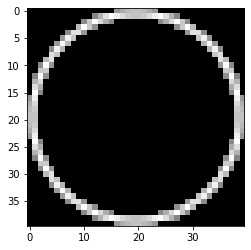

In [11]:
import itertools
import numpy as np
import random as rn
    # size=40 
    # thick = 1
MaxPix = np.max(Image)
MinPix = np.min(Image)

def getFuzzyMask( size, thick = 1. ):
    radius = size //2-1
    center = np.array([size/2-.5,size/2-.5])
    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    #ring mask
    ring = np.ones((size,size), dtype=np.float32) #np.random.rand(size,size)
    # print(selectedVecs.T[2])
    # print(np.max(selectedVecs.T[2]))
    maxMask= np.max(selectedVecs.T[2])
    ring = -(ring - MinPix)/(MaxPix-MinPix)
    
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]=k/maxMask

    return ring
plt.imshow(getFuzzyMask(40,1),cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)


###One example of arbitrary ring

Conv value: -0.23938815451312112


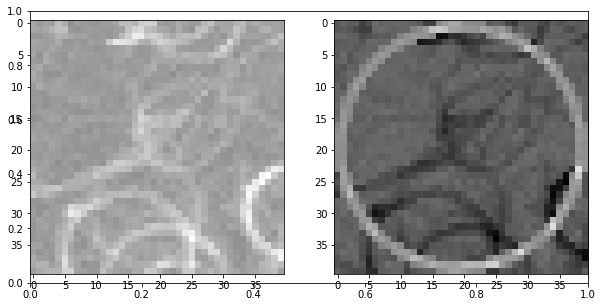

In [12]:
Mask = getFuzzyMask( MaxSize, 1 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)

ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('Conv value:',FuzzyCircleConv(square,Mask)/MaxSize**2)


###One example of founded ring

conv value -0.08034258328586487


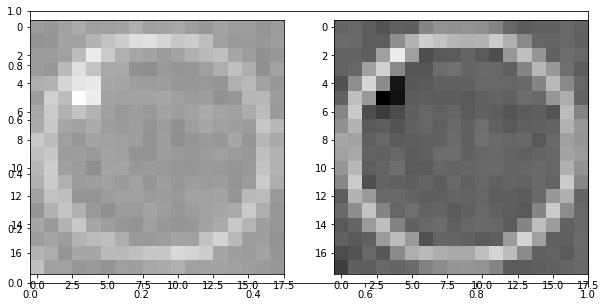

In [13]:
#SquareSize=20, (x,y)= 57, 13

x=58
y=13
size=18
Mask = getFuzzyMask( size, 1 )
square = Image[y:y+size, x:x+size]
    
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)
#ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
#ax1.imshow(Mask,alpha=.5)
ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('conv value', FuzzyCircleConv(square,Mask)/size**2)
#print(FuzzyCircleConv(square,Mask))
# _DEBUG_=True
# print(isCircleFound(square, Mask))
# print(np.var(square[Mask]))
# _DEBUG_=False

### Main loops


In [36]:
  
  _mask=getFuzzyMask( 18, Thick )
  mask_size = _mask.shape[0]
  pad_size = mask_size // 2
  rem = mask_size % 2
  horisontal_pad = np.zeros((ImageSize[0], pad_size), dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (mask.shape)
  view_shape = tuple(np.subtract(a.shape, sub_shape )+ rem ) + sub_shape
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  import math
  num = np.abs(math.sqrt(len(sub_matrices)))
  fig = plt.gcf()
  fig.set_size_inches(1*2 , 5*2 )

  i=0
  #SquareSize=18, (x,y)= 58, 13
  x=58
  y=13
  posy = y + pad_size
  posx = x + pad_size
  index = ImageSize[1] * posy + posx

  for img in sub_matrices[index-2:index+3,:,:]:
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(1, 5, i+1 )
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(img,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    i+=1
  plt.show()

<Figure size 144x720 with 0 Axes>

In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def conv(_mask):
  mask_size = _mask.shape[0]
  pad_size = mask_size // 2
  rem = mask_size % 2
  horisontal_pad = np.zeros((ImageSize[0], pad_size), dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (mask.shape)
  view_shape = tuple(np.subtract(a.shape, sub_shape )+ rem ) + sub_shape
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)


  m=np.sum(sub_matrices*_mask, axis=(2,3))/mask_size**2
  #m = np.einsum('ij,ijkl->kl',mask,sub_matrices)
  return m


In [20]:
ConvMatrices = np.empty((0,ImageSize[0],ImageSize[1]))
print(ConvMatrices.shape)
for size in range(MinSize,MaxSize):
  mask = getFuzzyMask( size, Thick )
  #print('size '+str(size))
  res = conv(mask)
  ConvMatrices= np.concatenate((ConvMatrices, np.reshape(res,(1,ImageSize[0],ImageSize[1]))),axis=0)

print(ConvMatrices.shape)
# for y in range(0,ImageSize[0]-size):
    # for x in range(0, ImageSize[1] - size):
    #   square = Image[y:y+size, x:x+size]
    #   ConvMatrices[y,x, size - MinSize] = FuzzyCircleConv(square,mask)
    #   # fig, ax = plt.subplots()
    #   # ax = fig.add_subplot(1,2,1)
    #   # ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #   # ax1=fig.add_subplot(1,2,2)
    #   # ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #   # ax1.imshow(mask,alpha=.5)
    #   # fig.show()
    #   # print([(x,y),size])
      

    

(0, 48, 64)
(30, 48, 64)


In [22]:
# x=58
# y=13
# size=18
# conv value -0.08034258328586487
print(ConvMatrices[6:9,10:14,56:59])


[[[-0.16826739 -0.15594443 -0.14800128]
  [-0.1692166  -0.14731828 -0.14056386]
  [-0.15878331 -0.14134702 -0.14284389]
  [-0.15277941 -0.14090831 -0.14432158]]

 [[-0.17406527 -0.15997689 -0.15182134]
  [-0.16456578 -0.15659599 -0.14940312]
  [-0.15908274 -0.15509648 -0.14994998]
  [-0.15509714 -0.15591398 -0.15849702]]

 [[-0.16403691 -0.15914849 -0.15203807]
  [-0.1563085  -0.15535749 -0.15013815]
  [-0.1501344  -0.1515896  -0.14807253]
  [-0.1480535  -0.15486469 -0.15109209]]]


In [0]:
# outfile = TemporaryFile()
np.save('ConvMatrices', FoundCircles)

In [0]:
plt.imshow()

10 -0.02110069291601538
10 -0.028665004070355087
10 -0.028988025383225376
10 -0.028120257001450204
10 -0.022450619966097873
10 -0.02845630599988869
10 -0.027089391012157106
10 -0.024691150255501233
10 -0.029070380462884647
10 -0.029159863436257052
10 -0.029401621032238062
10 -0.028155811605808666
10 -0.029534069974162712
10 -0.028810235960291114
10 -0.0260446064618089
12 -0.026799587318947844
12 -0.029515894795624793
12 -0.02919134920404154


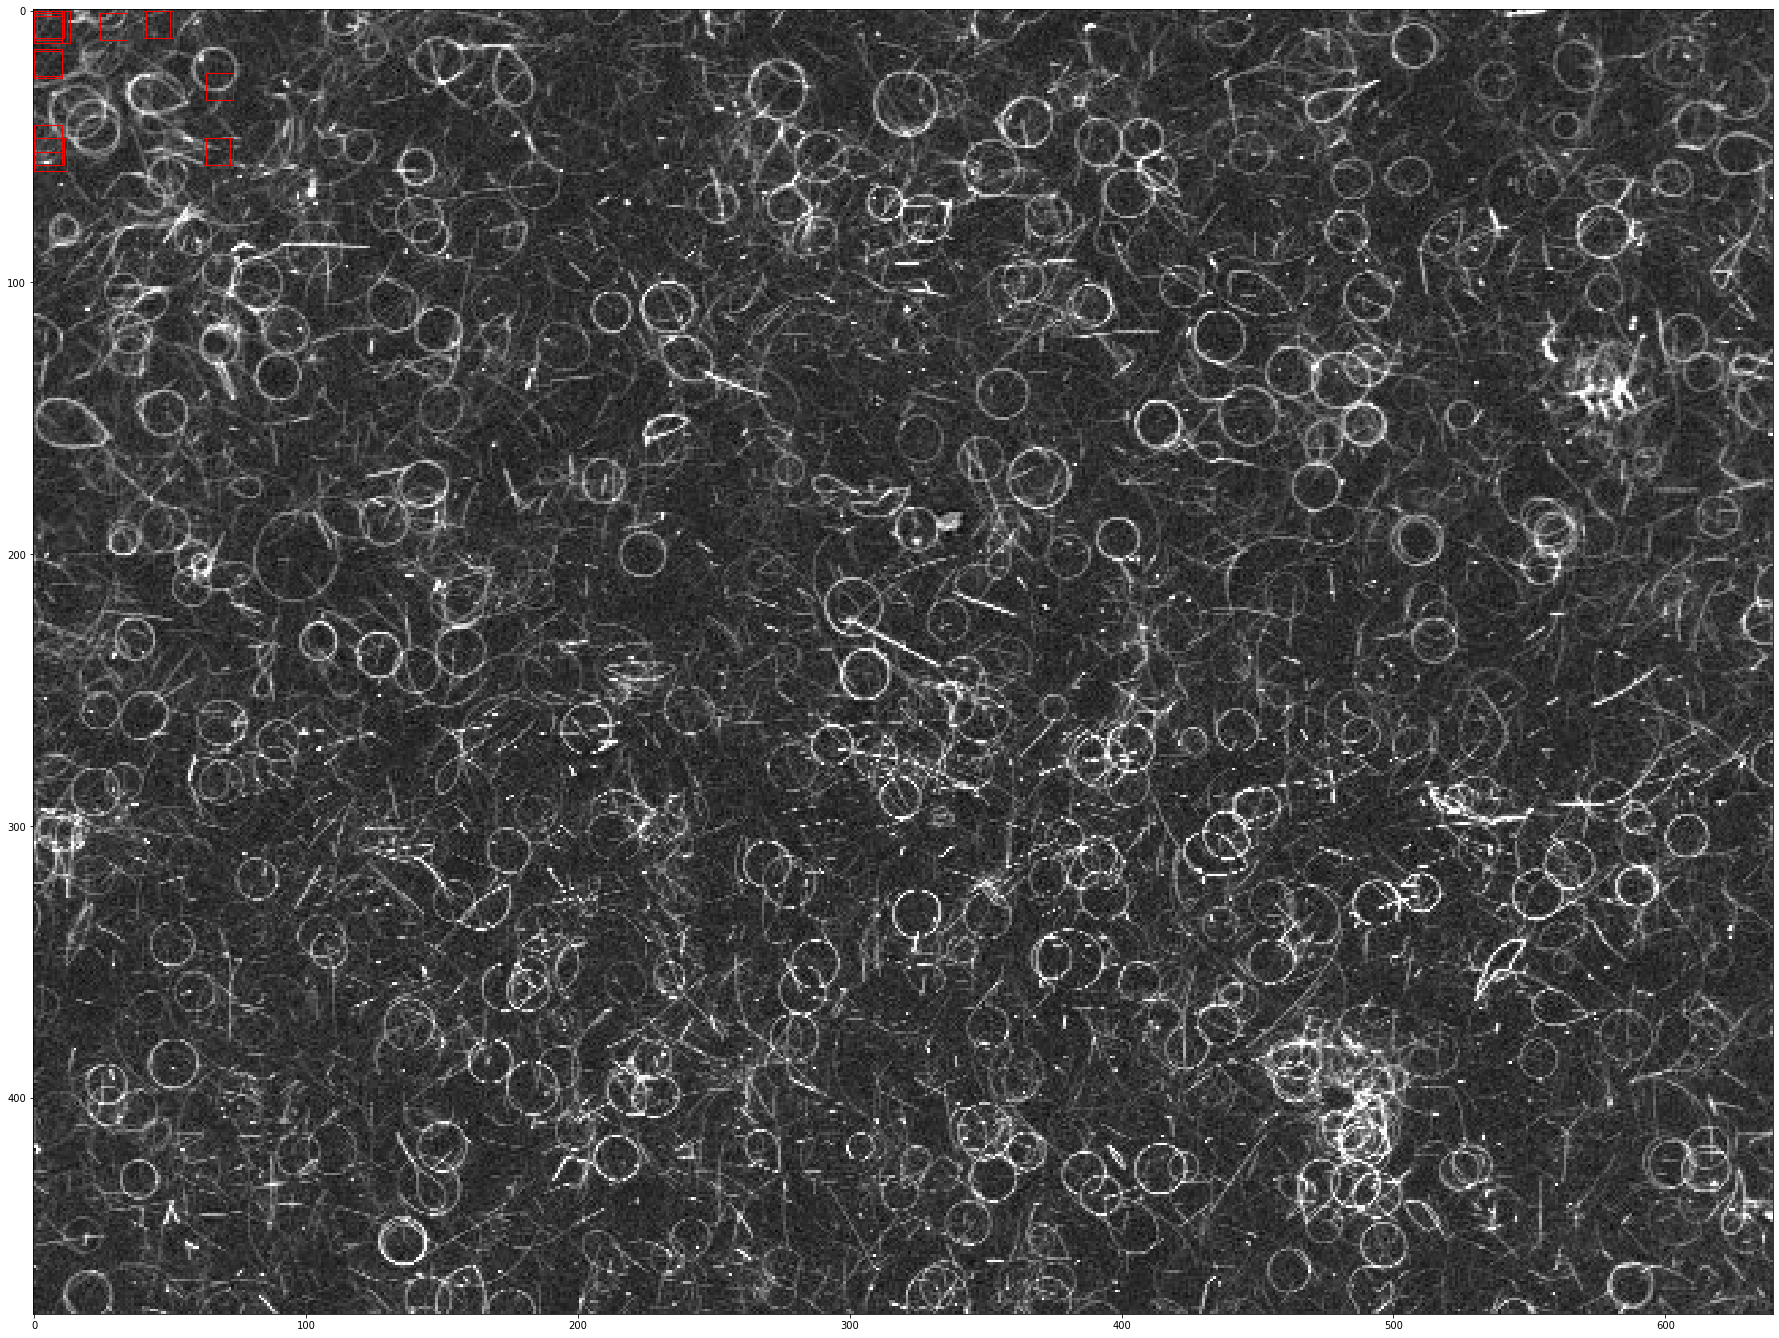

In [22]:
import matplotlib.patches as patches
# plt.ioff()
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(Image,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch
rect_size = MinSize
x=0
for cnv in ConvMatrices:
  for y in range(cnv.shape[0]):
    for x in range(cnv.shape[1]):
      if (cnv[y,x]>-0.03):
        print(rect_size, cnv[y,x])
        rect = patches.Rectangle((x,y),rect_size,rect_size,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
  rect_size+=1
plt.show()

In [0]:
#[(30, 101), 40]
y=101
x=30
size = 40
square = Image[y:y+size, x:x+size]
mask = getMask( size, Thick )
arr = square[mask]
box = square
st = (lambda arr: np.mean((arr-np.min(arr))))
print (st(box[mask]))
print (st(box[~mask]))
print(np.var(box[mask]))
